In [ ]:
import sys
sys.path.append("../../functions")
from GS_data1d import intensity_profile, construct_DM1d, propagation_dm1d
from scipy.io import loadmat
import numpy as np
from matplotlib import pyplot as plt
from scipy.linalg import eigh
from abtem.core.energy import energy2wavelength

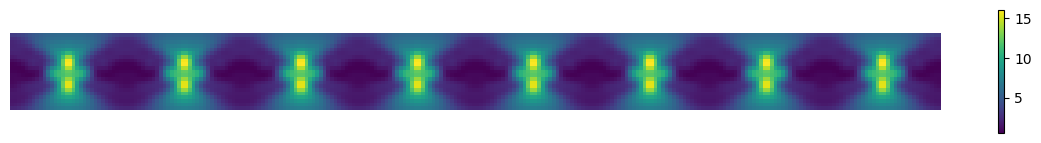

In [ ]:
image_series = loadmat("../../data/Core_loss_3bc_STO/STO_3bc_simulation_large_defocus.mat")["images"]
n_row, n_col, n_df = image_series.shape
focal_series = np.sum(image_series, axis=1)
num_repeat = 8
focal_series = np.tile(focal_series.T, num_repeat).T[:,7:-7]
n_rowp = focal_series.shape[0]
defocus = np.arange(-28, 14, 2)*10
a = 3.905
rx = np.linspace(-a/2*num_repeat, a/2*num_repeat, n_rowp)
sampling = rx[1]-rx[0]; energy=300e3
fig, ax = plt.subplots(figsize=(15, 8))
im=ax.imshow(focal_series.T)
ax.axis("off")
fig.colorbar(im, shrink=0.2)
plt.show()

In [3]:
alpha = 0.5e-3
Cs = 1e-3
delta = 1
dm_rec, drift_list, stack_1dp = construct_DM1d(rx, focal_series, defocus, sampling, energy, 
                                               n_iter=500, 
                                               apply_tcc=False,
                                               alpha=alpha, 
                                               Cs=Cs,
                                               delta=delta)

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [02:01<00:00,  4.10it/s]


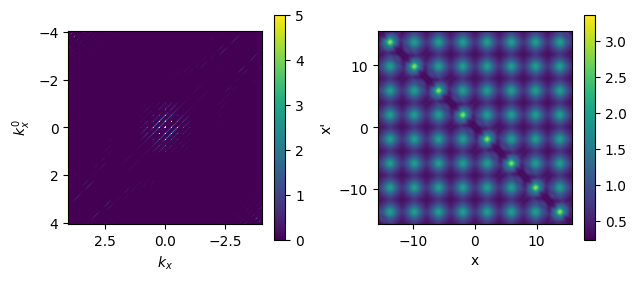

In [5]:
kx = np.fft.fftfreq(n_rowp, sampling)
ak = np.max(kx)
kdm_rec = np.fft.fftshift(np.fft.fft2(dm_rec))
length = dm_rec.shape[0]
plt.subplot(1, 2, 1)
plt.imshow(np.abs(kdm_rec/np.trace(kdm_rec)*length), extent=[ak, -ak, ak, -ak], vmax=5)
plt.colorbar(shrink=0.5)
plt.xlabel(r"$k_x$")
plt.ylabel(r"$k_x'$")
#plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(np.abs(dm_rec/np.trace(dm_rec)*length), extent=[-a*num_repeat/2, a*num_repeat/2, -a*num_repeat/2, a*num_repeat/2])
plt.colorbar(shrink=0.5)
plt.xlabel("x")
plt.ylabel("x'")
#plt.axis("off")
plt.tight_layout()
plt.show()

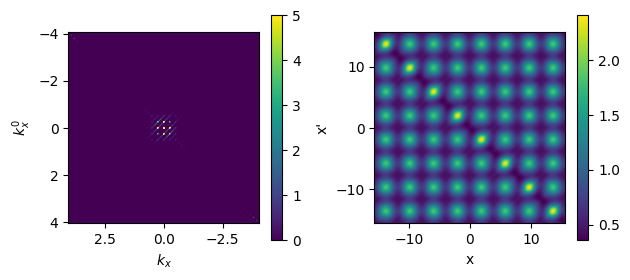

In [6]:
K, Kp = np.meshgrid(kx, kx)
wavelength = energy2wavelength(energy)
delta = 100
alpha = 1e-3
Cs = 1e-3
E_delta = np.exp(-1/2*(np.pi*wavelength*delta)**2*(K**2-Kp**2)**2)
E_alpha = np.exp(-(np.pi*alpha/wavelength)**2*Cs*wavelength**3*(K**3-Kp**3)**2)
TCC = E_alpha * E_delta
dm_damped = np.fft.ifft2(np.fft.fft2(dm_rec)*TCC)
kdm_damped = np.fft.fftshift(np.fft.fft2(dm_rec)*TCC)
plt.subplot(1, 2, 1)
plt.imshow(np.abs(kdm_damped/np.trace(kdm_damped)*length), extent=[ak, -ak, ak, -ak], vmax=5)
plt.colorbar(shrink=0.5)
plt.xlabel(r"$k_x$")
plt.ylabel(r"$k_x'$")
#plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(np.abs(dm_damped/np.trace(dm_damped)*length), extent=[-a*num_repeat/2, a*num_repeat/2, -a*num_repeat/2, a*num_repeat/2])
plt.colorbar(shrink=0.5)
plt.xlabel("x")
plt.ylabel("x'")
#plt.axis("off")
plt.tight_layout()
plt.show()

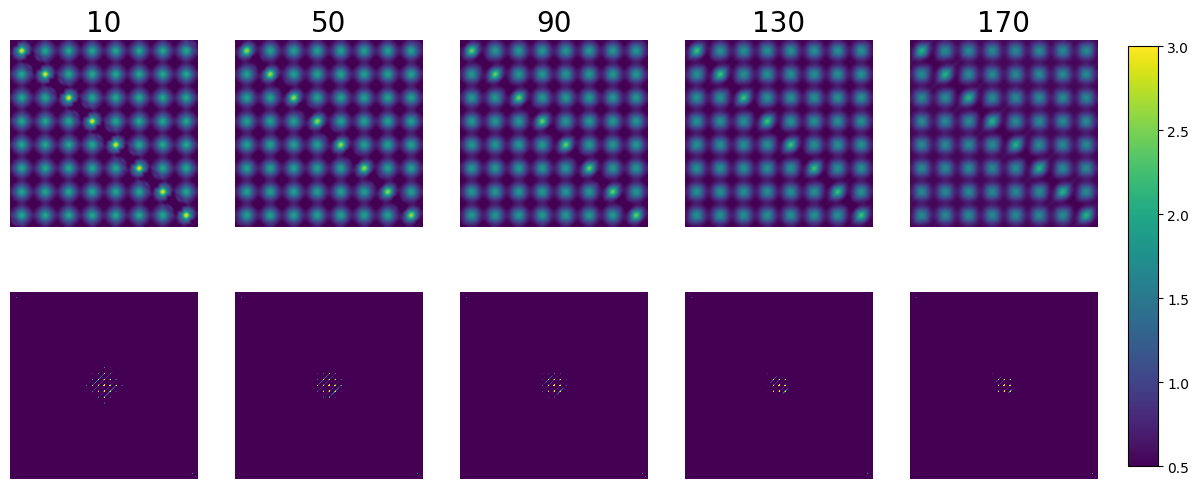

In [9]:
K, Kp = np.meshgrid(kx, kx)
wavelength = energy2wavelength(energy)
delta_range = np.arange(10, 200, 40)
fig, axs = plt.subplots(2, len(delta_range), figsize=(15, 6))
vmin_r = 0.5; vmax_r = 3; vmin_k = 0.5; vmax_k = 3
for index, delta in enumerate(delta_range):
    alpha = 1e-3
    Cs = 1e-3
    E_delta = np.exp(-1/2*(np.pi*wavelength*delta)**2*(K**2-Kp**2)**2)
    E_alpha = np.exp(-(np.pi*alpha/wavelength)**2*Cs*wavelength**3*(K**3-Kp**3)**2)
    TCC = E_alpha * E_delta
    dm_damped = np.fft.ifft2(np.fft.fft2(dm_rec)*TCC)
    kdm_damped = np.fft.fftshift(np.fft.fft2(dm_rec)*TCC)
    ax = axs[0, index]
    ax.set_title(f"{delta}", fontsize=20)
    im = ax.imshow(np.abs(dm_damped/np.trace(dm_damped)*length), extent=[-a*num_repeat/2, a*num_repeat/2, -a*num_repeat/2, a*num_repeat/2], vmin=vmin_r, vmax=vmax_r)
    ax.axis("off")
    ax = axs[1, index]
    im = ax.imshow(np.abs(kdm_damped/np.trace(kdm_damped)*length), extent=[ak, -ak, ak, -ak], vmin=vmin_k, vmax=vmax_k)
    ax.axis("off")
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.87, 0.15, 0.02, 0.7])
fig.colorbar(im, cax=cbar_ax)
# Adjust layout to be tight
#plt.tight_layout(rect=[0, 0, 0.85, 1])
#plt.tight_layout()
plt.show()

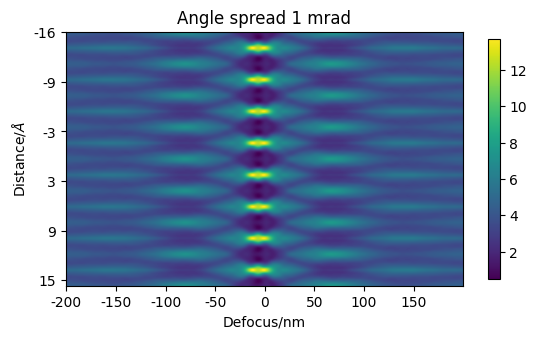

In [10]:
#extend_defocus = defocus
extend_defocus = np.arange(-200, 200, 1)*10
defocus_stack = []
for i, df in enumerate(extend_defocus):
    dm_prop = propagation_dm1d(dm_rec, df, energy, sampling, apply_tcc=True, alpha=1e-3, Cs=1e-3, delta=10)
    intensity = intensity_profile(dm_prop)
    #comparison = focal_series[:,i]
    defocus_stack.append(intensity)
defocus_stack = np.array(defocus_stack)
plt.imshow(defocus_stack.T)
x_labels = np.arange(0, len(extend_defocus), 50)
xlab = [f"{extend_defocus[i]/10:.0f}" for i in x_labels]
plt.xticks(ticks=x_labels, labels=xlab)
y_labels = np.arange(0, len(rx), 50)
ylab = [f"{rx[i]:.0f}" for i in y_labels]
plt.yticks(ticks=y_labels, labels=ylab)
plt.xlabel("Defocus/nm")
plt.ylabel(r"Distance/$\AA$")
plt.colorbar(shrink=0.65)
plt.title("Angle spread 1 mrad")
plt.show()

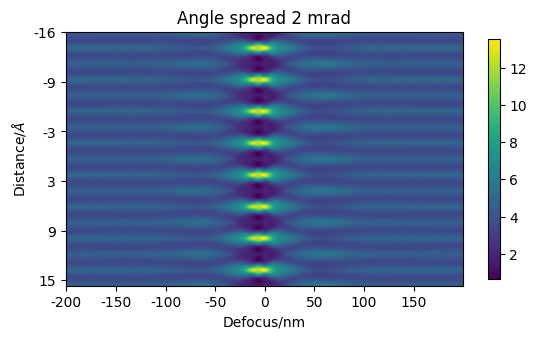

In [11]:
#extend_defocus = defocus
extend_defocus = np.arange(-200, 200, 1)*10
defocus_stack = []
for i, df in enumerate(extend_defocus):
    dm_prop = propagation_dm1d(dm_rec, df, energy, sampling, apply_tcc=True, alpha=2e-3, Cs=1e-3, delta=10)
    intensity = intensity_profile(dm_prop)
    #comparison = focal_series[:,i]
    defocus_stack.append(intensity)
defocus_stack = np.array(defocus_stack)
plt.imshow(defocus_stack.T)
x_labels = np.arange(0, len(extend_defocus), 50)
xlab = [f"{extend_defocus[i]/10:.0f}" for i in x_labels]
plt.xticks(ticks=x_labels, labels=xlab)
y_labels = np.arange(0, len(rx), 50)
ylab = [f"{rx[i]:.0f}" for i in y_labels]
plt.yticks(ticks=y_labels, labels=ylab)
plt.xlabel("Defocus/nm")
plt.ylabel(r"Distance/$\AA$")
plt.colorbar(shrink=0.65)
plt.title("Angle spread 2 mrad")
plt.show()

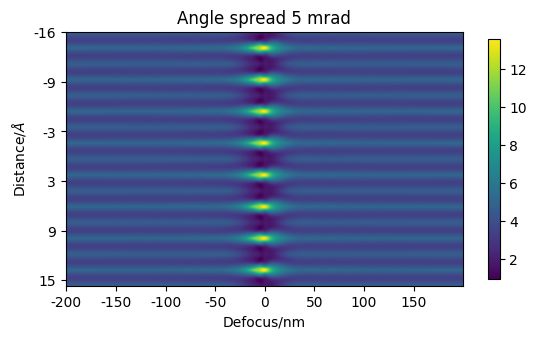

In [12]:
#extend_defocus = defocus
extend_defocus = np.arange(-200, 200, 1)*10
defocus_stack = []
for i, df in enumerate(extend_defocus):
    dm_prop = propagation_dm1d(dm_rec, df, energy, sampling, apply_tcc=True, alpha=5e-3, Cs=1e-3, delta=10)
    intensity = intensity_profile(dm_prop)
    #comparison = focal_series[:,i]
    defocus_stack.append(intensity)
defocus_stack = np.array(defocus_stack)
plt.imshow(defocus_stack.T)
x_labels = np.arange(0, len(extend_defocus), 50)
xlab = [f"{extend_defocus[i]/10:.0f}" for i in x_labels]
plt.xticks(ticks=x_labels, labels=xlab)
y_labels = np.arange(0, len(rx), 50)
ylab = [f"{rx[i]:.0f}" for i in y_labels]
plt.yticks(ticks=y_labels, labels=ylab)
plt.xlabel("Defocus/nm")
plt.ylabel(r"Distance/$\AA$")
plt.colorbar(shrink=0.65)
plt.title("Angle spread 5 mrad")
plt.show()